In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("social_media_engagement.csv")

In [5]:
print(df.head())
print(df.info())

   Post ID   Platform Engagement Type  User ID  Engagement Count   Post Date
0        1    Twitter            Like     1676               205  2023-01-24
1        2   LinkedIn           Share     1222               886  2016-01-15
2        3   LinkedIn           Share     1915               625  2024-11-16
3        4   Facebook           Share     4574               718  2019-10-23
4        5  Instagram         Comment     4536               196  2022-10-24
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Post ID           50000 non-null  int64 
 1   Platform          50000 non-null  object
 2   Engagement Type   50000 non-null  object
 3   User ID           50000 non-null  int64 
 4   Engagement Count  50000 non-null  int64 
 5   Post Date         50000 non-null  object
dtypes: int64(3), object(3)
memory usage: 2.3+ MB
None


In [6]:
# Check missing values
print(df.isnull().sum())

# Check duplicates
print("Duplicates:", df.duplicated().sum())

# Check data types
print(df.dtypes)

Post ID             0
Platform            0
Engagement Type     0
User ID             0
Engagement Count    0
Post Date           0
dtype: int64
Duplicates: 0
Post ID              int64
Platform            object
Engagement Type     object
User ID              int64
Engagement Count     int64
Post Date           object
dtype: object


In [8]:
 #Pivot table to reshape Engagement Type into columns
pivot_df = df.pivot_table(
    index=["Post ID", "Platform", "Post Date"],
    columns="Engagement Type",
    values="Engagement Count",
    aggfunc="sum",
    fill_value=0
).reset_index()

# Rename columns for clarity
pivot_df.columns.name = None
pivot_df.rename(columns={"Like": "Likes", "Comment": "Comments", "Share": "Shares"}, inplace=True)

# Add Impressions column (assuming it's sum of all engagements for now)
pivot_df["Impressions"] = pivot_df["Likes"] + pivot_df["Comments"] + pivot_df["Shares"]

pivot_df.head()

,Post ID,Platform,Post Date,Comments,Likes,Shares,Impressions
0,1,Twitter,2023-01-24,0,205,0,205
1,2,LinkedIn,2016-01-15,0,0,886,886
2,3,LinkedIn,2024-11-16,0,0,625,625
3,4,Facebook,2019-10-23,0,0,718,718
4,5,Instagram,2022-10-24,196,0,0,196


In [9]:
pivot_df["Engagement Rate"] = (
    (pivot_df["Likes"] + pivot_df["Comments"] + pivot_df["Shares"]) / pivot_df["Impressions"]
).round(4)


In [11]:
from sklearn.preprocessing import LabelEncoder

# Encode Platform
platform_encoder = LabelEncoder()
pivot_df["Platform_Encoded"] = platform_encoder.fit_transform(pivot_df["Platform"])

# Extract Day of Week & Hour of Day
pivot_df["Post Date"] = pd.to_datetime(pivot_df["Post Date"], errors="coerce")
pivot_df["DayOfWeek"] = pivot_df["Post Date"].dt.day_name()
pivot_df["HourOfDay"] = pivot_df["Post Date"].dt.hour

# Encode Day of Week
day_encoder = LabelEncoder()
pivot_df["DayOfWeek_Encoded"] = day_encoder.fit_transform(pivot_df["DayOfWeek"].astype(str))

pivot_df.head()


,Post ID,Platform,Post Date,Comments,Likes,Shares,Impressions,Engagement Rate,Platform_Encoded,DayOfWeek,HourOfDay,DayOfWeek_Encoded
0,1,Twitter,2023-01-24,0,205,0,205,1.0,3,Tuesday,0,5
1,2,LinkedIn,2016-01-15,0,0,886,886,1.0,2,Friday,0,0
2,3,LinkedIn,2024-11-16,0,0,625,625,1.0,2,Saturday,0,2
3,4,Facebook,2019-10-23,0,0,718,718,1.0,0,Wednesday,0,6
4,5,Instagram,2022-10-24,196,0,0,196,1.0,1,Monday,0,1


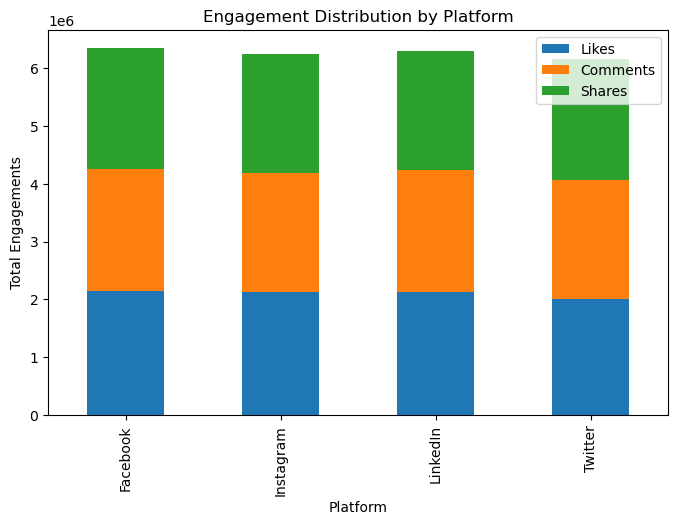

In [12]:
#2: Exploratory Data Analysis (EDA)
#Plot engagement distribution by platform

import matplotlib.pyplot as plt
import seaborn as sns

# Engagement per platform
platform_engagement = pivot_df.groupby("Platform")[["Likes", "Comments", "Shares"]].sum()

# Plot
platform_engagement.plot(kind="bar", stacked=True, figsize=(8,5))
plt.title("Engagement Distribution by Platform")
plt.ylabel("Total Engagements")
plt.xlabel("Platform")
plt.show()

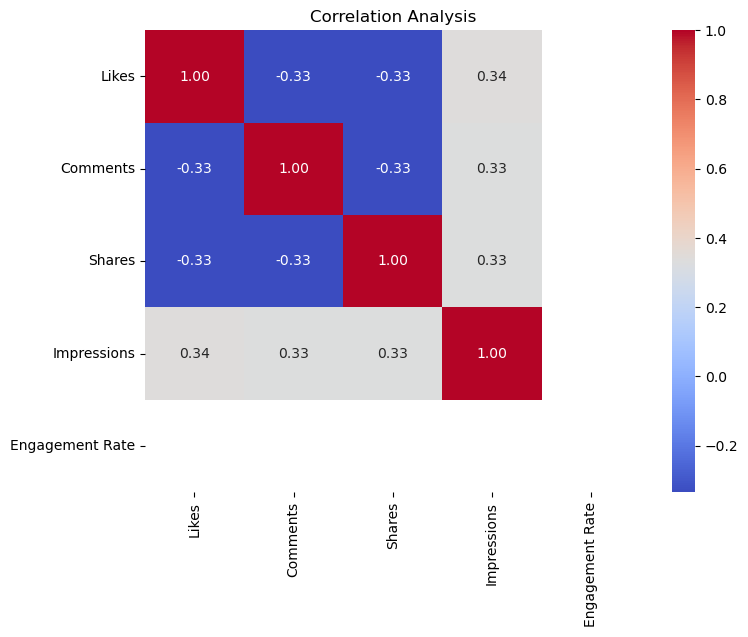

In [13]:
# Select numeric columns
numeric_cols = ["Likes", "Comments", "Shares", "Impressions", "Engagement Rate"]

# Correlation matrix
corr = pivot_df[numeric_cols].corr()

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Analysis")
plt.show()

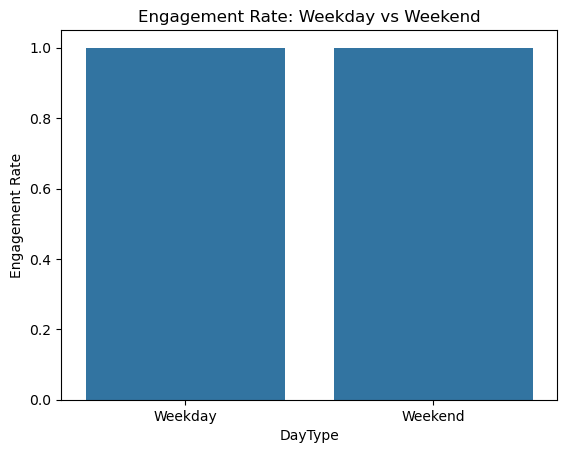

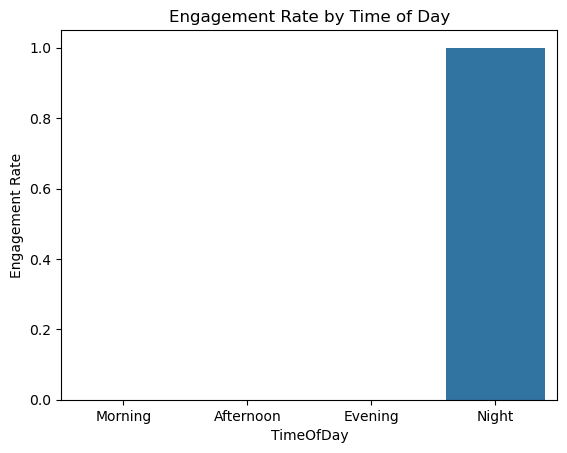

In [14]:
#Check best posting time (weekday vs weekend, morning vs evening)

# Create new features
pivot_df["DayType"] = pivot_df["DayOfWeek"].apply(lambda x: "Weekend" if x in ["Saturday", "Sunday"] else "Weekday")
pivot_df["TimeOfDay"] = pivot_df["HourOfDay"].apply(
    lambda h: "Morning" if 5 <= h < 12 else ("Afternoon" if 12 <= h < 17 else ("Evening" if 17 <= h < 22 else "Night"))
)

# Avg engagement by DayType
sns.barplot(x="DayType", y="Engagement Rate", data=pivot_df)
plt.title("Engagement Rate: Weekday vs Weekend")
plt.show()

# Avg engagement by TimeOfDay
sns.barplot(x="TimeOfDay", y="Engagement Rate", data=pivot_df, order=["Morning","Afternoon","Evening","Night"])
plt.title("Engagement Rate by Time of Day")
plt.show()

In [15]:
#3.Feature Engineering:Steps & Solution

# Convert to datetime if not already
pivot_df["Post Date"] = pd.to_datetime(pivot_df["Post Date"], errors="coerce")

# Extract features
pivot_df["day_of_week"] = pivot_df["Post Date"].dt.day_name()
pivot_df["hour_of_day"] = pivot_df["Post Date"].dt.hour


In [16]:
#Convert hashtags count into numeric feature

# If hashtags column exists
if "Hashtags" in pivot_df.columns:
    pivot_df["hashtags_count"] = pivot_df["Hashtags"].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
else:
    # If not available, create dummy column for demo
    pivot_df["hashtags_count"] = 0

In [17]:
#Normalize numerical values

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Select numerical features
num_features = ["Likes", "Comments", "Shares", "Impressions", "hashtags_count"]

# MinMax Scaling
scaler_minmax = MinMaxScaler()
pivot_df[[f"{col}_scaled" for col in num_features]] = scaler_minmax.fit_transform(pivot_df[num_features])

# Standard Scaling (z-score normalization)


scaler_standard = StandardScaler()
pivot_df[[f"{col}_std" for col in num_features]] = scaler_standard.fit_transform(pivot_df[num_features])